Import Necessary Libraries

In [16]:
import random
from math import log
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import treebank, stopwords 
from nltk.tokenize import word_tokenize
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder

The purpose of the project is to learn how to tag words with part-of-speeches. This particular task is important in Natural Language Process literature, because it is one of the preprocessing stages for other tasks like Named-Entity-Recognition, Text Summarization and so forth. In such other tasks, extracting words like noun and verb is particularly important. Given such context, we would like to propose Hidden Markov Model for part-of-speech tagger, a bayesian approach to infer the most likely sequence of tags given a sentence.

In this model, words would be considered emissions, and the part-of-speechs would be the hidden states. We will learn both transition and emission probability of the hidden states through a corpus. There are multiple ways to implement this; the specific blog entry will work with bi-gram meaning that it would use only the current hidden state along with the emission to predict the following hidden state. This property is called the "Markov Property," and the assumption is that the future outputs do not depend on past inputs. We could also loosen up the markov property by using tri-grams and quadi-grams: using current and the past or current and the previous two hidden states to learn the transition probabilities. However there could be a few drawbacks both computationally and performance-wise as the required corpus size to learn the priors blow up exponentially.

NLTK (Natural Language Toolkit) libarary is one of the most well-known libararies for natural language processing in python. It provides various datasets along with useful functions such as sentence tokenizers and so forth. In this blogpost, we will specifically be working with the Penn Treebank dataset that contains the Wall Street Journal data and its pos tags. The dataset can be downloaded directly through nltk library interface.

In [32]:
# Download data from nltk library
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('stopwords')


class WSJData(object):
    def __init__(self, seed = 42):
        random.seed(seed)
        
        # Load Wall Street Journal Dataset
        self.data = treebank.tagged_sents(tagset='universal')
        
        # Statistics of the Dataset
        self.num_sents = len(self.data)
        self.num_tokens = sum([len(x) for x in self.data])
        self.words, self.tags = set(), set()

        # Construct word and tag sets
        for s in self.data:
            w, t = zip(*s)
            self.words = self.words.union(set(w))
            self.tags = self.tags.union(set(t))
            
        # Split dataset into train set and test set
        sents = list(self.data)
        random.shuffle(sents)
        split_point = round(len(sents) * 0.8)

        self.train = sents[:split_point]
        self.test = sents[split_point:]

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\jkim0\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\jkim0\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jkim0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

Before we start any natural language processing on the dataset, we would like to go over what the dataset looks like to give a bit more context to the project. The following is what the first sentence in the Wall Street Journal looks like with its pos tag.

In [3]:
wsj = WSJData()
sample_sentence = pd.DataFrame(wsj.data[0]) # see how the dataset looks like
sample_sentence.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Pierre,Vinken,",",61,years,old,",",will,join,the,board,as,a,nonexecutive,director,Nov.,29,.
1,NOUN,NOUN,.,NUM,NOUN,ADJ,.,VERB,VERB,DET,NOUN,ADP,DET,ADJ,NOUN,NOUN,NUM,.


Word Statistics Summary

In [4]:
# We didn't lower case words so the number of words would actually be greater than expected
print("# Sentences: {}\n# Tokens: {}\n# Words: {}\n# Tags: {}".format(wsj.num_sents, wsj.num_tokens, len(wsj.words), len(wsj.tags)))
print(wsj.tags)

# Sentences: 3914
# Tokens: 100676
# Words: 12408
# Tags: 12
{'.', 'ADJ', 'CONJ', 'ADP', 'PRT', 'ADV', 'VERB', 'NUM', 'DET', 'PRON', 'X', 'NOUN'}


In [5]:
wordfreq = defaultdict(lambda:0)
tagfreq = defaultdict(lambda:0)

for s in wsj.data:
    for w, t in s:
        wordfreq[w.lower()] += 1
        tagfreq[t] += 1

Distribution of Part of Speeches in the WSJ dataset

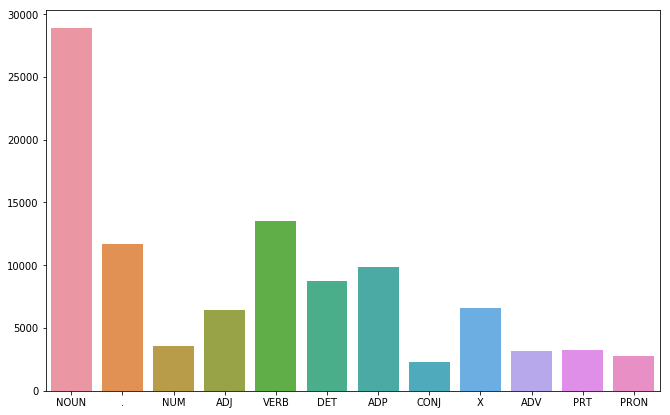

In [6]:
snsplot = sns.barplot(list(tagfreq.keys()), list(tagfreq.values()))
fig = snsplot.get_figure()
fig.set_size_inches(11, 7)
fig.savefig("tagfrequency.png")

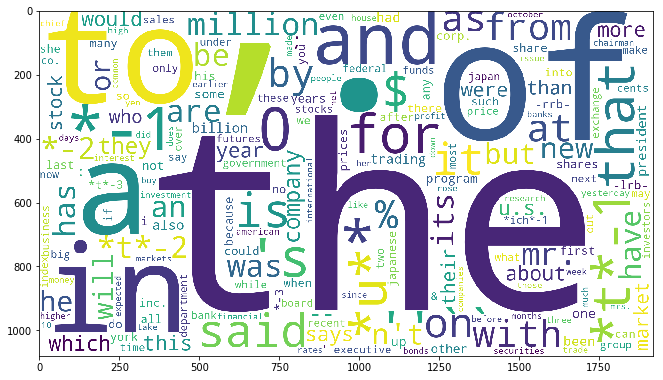

In [7]:
nltkstopwords = set(stopwords.words('english'))
snsstopwords = set(STOPWORDS)
stop = nltkstopwords.union(snsstopwords)

wordcloud = WordCloud(width = 1920, height = 1080, background_color = "white", stopwords = stop)
wc = wordcloud.generate_from_frequencies(wordfreq)

plt.figure(figsize=(11,7))
plt.imshow(wc)

Most common words in the corpus are the, of, a, and in. The most common words somewhat ironically are the most meaningless ones.
To find out words that are more significant, we decided to filter words based on whether it was a noun or not.

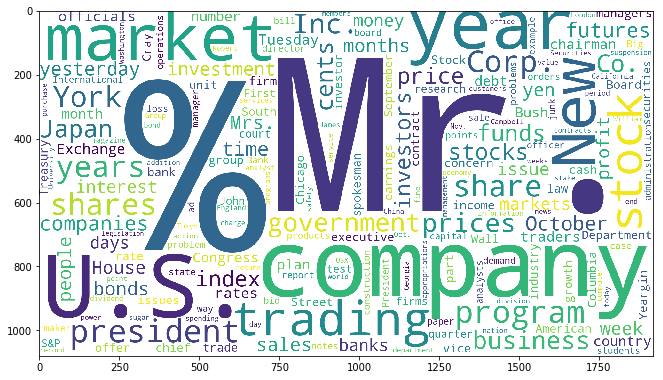

In [8]:
nfreq = defaultdict(lambda:0)

for s in wsj.data:
    for w, t in s:
        if t == "NOUN":
            nfreq[w] += 1
            
wc = wordcloud.generate_from_frequencies(nfreq)
plt.figure(figsize=(11,7))
plt.imshow(wc)

Now the produced wordcloud contains words with much higher information content. We believe this demonstrates the importance of part-of-speech tagging.

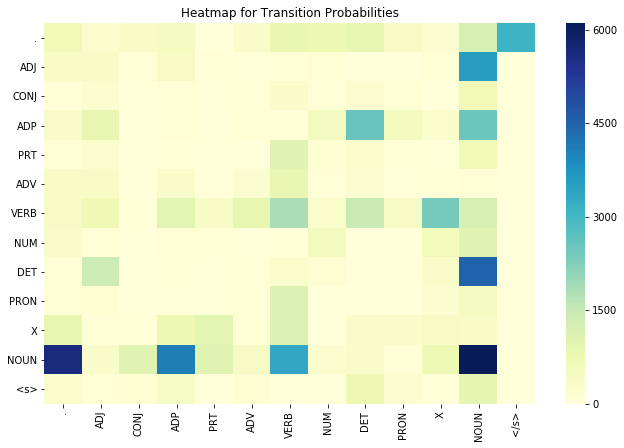

In [11]:
index = list(wsj.tags)
cols = list(wsj.tags)
df = pd.DataFrame(index = index, columns = cols)

for key in hmm.t_freq:
    df.loc[key] = hmm.t_freq[key]


snsplot = sns.heatmap(df.fillna(0), cmap="YlGnBu")
snsplot.set_title("Heatmap for Transition Probabilities")
fig = snsplot.get_figure()
fig.set_size_inches(11, 7)

The last figure we decided to include was a heatmap for the transition probability. Transition probability in this context means how likely a transition is to happen from one tag to another. The rows indicate starting tag (state) and the columns indicate the ending tag. Note that these probabilities were actually populated through the training phase of hidden markov model. 

To our surprise, the transitions with highest probabilities was from noun to noun. We believe this happened for two reasons. First of all, the corpus has a abnormally high noun counts. Also, 
Now that we have a better sense of what the dataset looks like, we would like to proceed to training hidden markov models and using them to predict part-of-speech tags.

# Hidden Markov Models

The training process of the hidden markov will be to learn the emission probabilities (p(word|tag)) and the transition probabilities (p(tag t | tag t-1)). All of these will be recorded by traversing through the training data once.
There are a few implementation details worthwile of paying attention to.

1. We need to append <s> and </s> to the start and the end of each sentence. This would provide a meaningful transition to the first and last word within the sentence upon inference.
2. We need to transform the probabilities into log probabilities to avoid numerical underflows.
3. We need to add a baseline probability to avoid negative infinities upon inference. We might encounter words that we never saw upon inference. For example, the chance that the corpus might have seen an arbitrary number like 10,938,227 is slim. To avoid the program from having all equal -inf log probability, we will set 1 as the base frequency for unseen vocabulary and 2 for words only seen once. This technique is called "Laplacian Smoothing."

In [9]:
class HiddenMarkovModel(object):
    def __init__(self, data):
        self.t_freq = defaultdict(lambda:1)
        self.e_freq = defaultdict(lambda:1)
        self.tags = data.tags.union({'<s>','</s>'})
        
        for s in data.train:
            # modify sentence s.t. we can record transition for starts and ends
            ms = [('<s>', '<s>')] + s + [('</s>','</s>')]
            for i,token in enumerate(ms):
                w,t = token
                self.e_freq[(t,w.lower())] += 1
                if i + 1 == len(ms):
                    continue
                self.t_freq[(t,ms[i+1][1])] += 1
                
        st = sum(self.t_freq.values())
        et = sum(self.e_freq.values())
        
        self.transition = defaultdict(lambda:-log(1/st))
        self.emission = defaultdict(lambda:-log(1/et))

        for key in self.t_freq:
            self.transition[key] = -log(self.t_freq[key]/st)

        for key in self.e_freq:
            self.emission[key] = -log(self.e_freq[key]/et)
            
            
    def __call__(self, sentence):
        # prev sequences and their associated probabilities are stored
        prev_seq = dict()
        
        for t in self.tags:
            prev_seq[t] = ([t], float('inf'))
        prev_seq['<s>'] = (['<s>'], 0)

        s = ['<s>'] + list(sentence) + ['</s>']

        # Viterbi Reconstruction Algorithm
        for i in range(1,len(s)):
            word = s[i].lower()
            seq = defaultdict(lambda:[])
            # forward pass : find all probabilities
            for tag in self.tags:
                for prev_tag in self.tags:
                    sequence, prob = prev_seq[prev_tag]
                    new_prob = self.transition[(prev_tag, tag)] + self.emission[(tag,word)] + prob
                    seq[tag].append((sequence + [tag], new_prob))

            # backward pass : update most likely path
            for tag in self.tags:
                min_prob = float('inf')
                most_likely_sequence = [];
                for sequence, prob in seq[tag]:
                    if prob < min_prob:
                        #print(sequence,prob,str(prob<min_prob))
                        most_likely_sequence = sequence;
                        min_prob = prob
                prev_seq[tag] = (most_likely_sequence, min_prob)
                
        return prev_seq['</s>'][0][1:-1]

The inference algorithm for hidden markov model is known as the Viterbi reconstruction algorithm, which consists of a forward pass and a backward pass. The forward pass finds the probability for all possible state transitions, and the backward pass updates the most probable path for a given state. Although one could do a brute force search for all likely sequences, that would have an O(k^N) where k is the length of the sentence and N is the number of tags as opposed to the forward and backward pass that has an O(kN^2) complexity. Either way one of the downside of this model is that it has a short training time but long inference time.

In [10]:
hmm = HiddenMarkovModel(wsj)

In [33]:
s,t = zip(*wsj.test[0])
print(s)
print(t)
hmm(s)

('Terms', 'were', "n't", 'disclosed', '*-1', '.')
('NOUN', 'VERB', 'ADV', 'VERB', 'X', '.')


['NOUN', 'VERB', 'ADV', 'VERB', 'X', '.']

This is a sample inference of the model we trained. It correctly labels all the tags. We now evaluate the performance of the model on all the test set, and do a classification report / plot the confusion matrix of the results.

In [35]:
truth = []
pred = []

for tagged_sentence in wsj.test:
    sentence, true_tag = zip(*tagged_sentence)
    sent = [word.lower() for word in sentence]
    truth += list(true_tag)
    pred += hmm(sent)

In [36]:
report = classification_report(truth, pred, labels = list(wsj.tags))
print(report)

             precision    recall  f1-score   support

          .       0.97      1.00      0.99      2260
        ADJ       0.91      0.33      0.49      1256
       CONJ       1.00      0.93      0.96       434
        ADP       0.91      0.96      0.94      1933
        PRT       1.00      0.86      0.93       639
        ADV       0.96      0.29      0.45       648
       VERB       0.92      0.79      0.85      2676
        NUM       0.99      0.28      0.44       647
        DET       0.96      0.96      0.96      1699
       PRON       1.00      0.79      0.88       535
          X       0.98      0.89      0.93      1263
       NOUN       0.71      0.99      0.82      5665

avg / total       0.88      0.85      0.84     19655



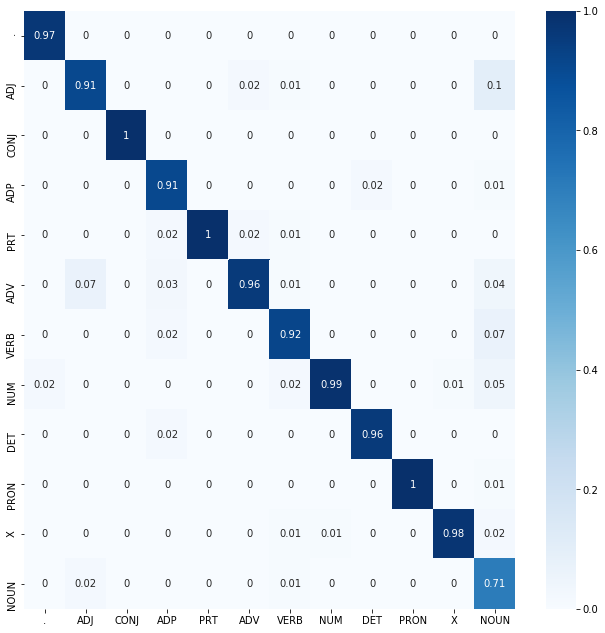

In [37]:
cm = pd.DataFrame(confusion_matrix(truth, pred, labels=list(wsj.tags)))
cm.columns = list(wsj.tags)
cm.index = list(wsj.tags)
cm = cm.astype('float') / cm.sum(axis=0)
cm = round(cm,2)

plt.figure(figsize=(11,11))
sns.heatmap(cm, annot=True, cmap="Blues")